In [16]:
import itertools
import pickle

import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Lc0sight("lc0.onnx", device=device)

Using device: cpu


First, we load a dataset of puzzles selected to be challenging but solvable for Leela:

In [4]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

Let's look at one of these puzzles:

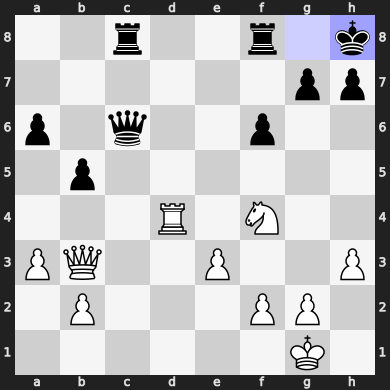

In [5]:
# This is the running example from the paper, you can pick a different one:
puzzle = puzzles.iloc[483]
# LeelaBoard instances can also be created from FENs or in other ways, but always
# use from_puzzle if you want to create one from a puzzle from the lichess dataset.
board = LeelaBoard.from_puzzle(puzzle)
board

The *principal variation* is the best sequence of moves for both sides:

In [6]:
puzzle.principal_variation

['f4g6', 'h7g6', 'd4h4']

Leela solves this puzzle correctly:

In [7]:
model.pretty_play(board)

Ng6+: 57.87%
a4: 9.01%
Kh2: 8.27%
h4: 8.08%
Qd3: 3.91%
W: 28.72%, D: 49.91%, L: 21.37%


# Visualizing attention patterns

Next, let's look at some attention patterns. These are 64 x 64 arrays, with one entry for each pair of squares.

In [8]:
layer = 9
head = 5

# We're using nnsight to cache activations and do interventions. There's also an interface
# based directly on pytorch hooks if you prefer that, see Lc0Model.capturing().
with model.trace(board):
    attention = model.attention_scores(layer).output[0, head].save()
attention.shape

torch.Size([64, 64])

We can plot slices of this attention pattern:

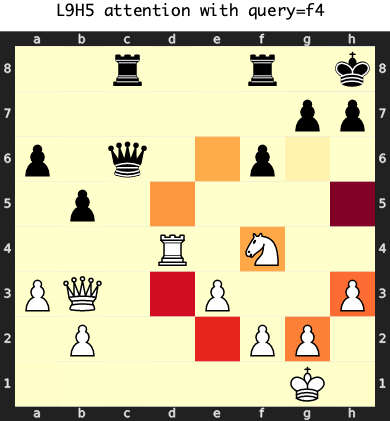

In [9]:
square = "f4"
# This converts a square in chess notation to the index inside Leela's activations for
# that square. Note that the input to Leela is flipped depending on the current player's
# color.
idx = board.sq2idx(square)
# attention has shape (query_dim, key_dim); indexing into the first one gives us a slice
# of the attention pattern with fixed query.
board.plot(attention[idx], caption=f"L{layer}H{head} attention with query={square}")

# Attention attribution

Let's look at L12H12 instead and do attention attribution (this is basically approximating a zero-ablation of individual attention weights). We'll then plot the entries with the highest attribution scores as arrows from key to query (i.e. in the direction of information flow).

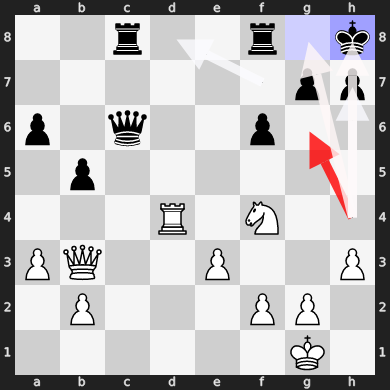

In [11]:
attribution = attention_attribution(
    [board], layer=12, head=12, model=model, return_pt=True
)[0]
values, colors = top_k_attributions(attribution, board, k=5)
board.plot(arrows=colors)

As discussed in the paper, it seems L12H12 is moving information from the 3rd move target square (h4) to the 1st move target (g6). Let's see what happens if we zero-ablate this single attention pattern entry:

In [13]:
query_square = puzzle.principal_variation[0][2:4]
key_square = puzzle.principal_variation[2][2:4]
query_idx = board.sq2idx(query_square)
key_idx = board.sq2idx(key_square)

with model.trace(board):
    model.attention_scores(12).output[0, 12, query_idx, key_idx] = 0
    output = model.output.save()

probs = model.logits_to_probs(board, output[0])[0]
policy = model.top_moves(board, probs, top_k=5)
print(policy)
print("WDL:", output[1])

{'a3a4': 0.19454805552959442, 'g1h2': 0.18257959187030792, 'h3h4': 0.16615894436836243, 'f4g6': 0.1618371605873108, 'b3d3': 0.07064661383628845}
WDL: tensor([[0.0993, 0.4908, 0.4100]])


The previous top move, Ng6, is now in 4th place at only 16%. Leela also thinks it's worse (the win probability is down to 9.9% from 28.7%).

# Activation patching

Finally, let's do activation patching. Every puzzle in our dataset already has a "corrupted version" that we automatically generated. This is a very similar board position, but with a slight difference that makes the tactic no longer work. Note the new pawn on h6:

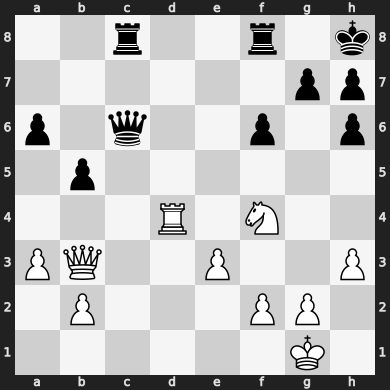

a4: 23.92%
Kh2: 23.56%
Qb4: 13.59%
Qd3: 6.72%
Ne6: 4.85%
W: 1.32%, D: 10.89%, L: 87.79%


In [14]:
corrupted_board = LeelaBoard.from_fen(puzzle.corrupted_fen)
display(corrupted_board)
model.pretty_play(corrupted_board)

We could implement activation patching fairly easily with `nnsight`, but we'll instead introduce our patching helper function. Let's patch the output of L12H12 on every square:

In [18]:
log_odds_reductions = -activation_patch(
    module_func=model.headwise_attention_output,
    # Layer, head, output square:
    locations=list(itertools.product([12], [12], range(64))),
    model=model,
    # We could also pass in board and corrupted_board manually instead
    puzzles=puzzle,
)
log_odds_reductions.shape

100%|██████████| 64/64 [00:03<00:00, 18.65it/s]


torch.Size([64])

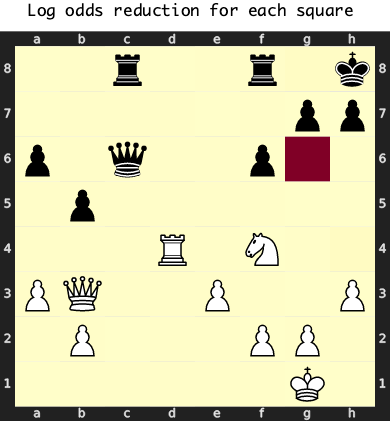

In [19]:
board.plot(log_odds_reductions, caption="Log odds reduction for each square")

As we can see, activation patching essentially only has a big effect on g6, where L12H12 moved information to from h4.

# Next steps
We demonstrated how to use several mechanistic interpretability techniques on a single board position. It's fairly straightforward to extend these to batches of positions, see the files in `scripts` for examples. `nnsight` also makes it quite easy to use other interpretability techniques that we didn't cover here.